## Data exploration

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Data loading

In [1]:
!unzip ../data/raw/filtered_paranmt.zip -d ../data/raw/

^C


In [2]:
df = pd.read_table('../data/raw/filtered.tsv', index_col=0)
df.reset_index(drop=True, inplace=True)
df.head()

,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
0,"If Alkar is flooding her with psychic waste, t...","if Alkar floods her with her mental waste, it ...",0.785171,0.010309,0.014195,0.981983
1,Now you're getting nasty.,you're becoming disgusting.,0.749687,0.071429,0.065473,0.999039
2,"Well, we could spare your life, for one.","well, we can spare your life.",0.919051,0.268293,0.213313,0.985068
3,"Ah! Monkey, you've got to snap out of it.","monkey, you have to wake up.",0.664333,0.309524,0.053362,0.994215
4,I've got orders to put her down.,I have orders to kill her.,0.726639,0.181818,0.009402,0.999348


In [3]:
df.shape

(577777, 6)

### Check for null values

In [4]:
def null_percentage(column):
    df_name = column.name
    nans = np.count_nonzero(column.isnull().values)
    total = column.size
    frac = nans / total
    perc = int(frac * 100)
    print('%d%% or %d missing from %s column.' %
          (perc, nans, df_name))


def check_null(df, columns):
    for col in columns:
        null_percentage(df[col])


check_null(df, df.columns)

0% or 0 missing from reference column.
0% or 0 missing from translation column.
0% or 0 missing from similarity column.
0% or 0 missing from lenght_diff column.
0% or 0 missing from ref_tox column.
0% or 0 missing from trn_tox column.


Therefore there is no need to generate missed values

### Basic metrics about the dataset

In [7]:
df.describe()

,similarity,lenght_diff,ref_tox,trn_tox
count,577777.000000,577777.000000,577777.000000,577777.000000
mean,0.758469,0.157652,0.541372,0.434490
std,0.092695,0.108057,0.457571,0.458904
min,0.600001,0.000000,0.000033,0.000033
25%,0.681105,0.066667,0.012171,0.000707
50%,0.754439,0.141791,0.806795,0.085133
75%,0.831244,0.238095,0.990469,0.973739
max,0.950000,0.400000,0.999724,0.999730


From the statistics we can conclude that:
1. Samples have a huge similarity, from 0.6 to 0.95.
2. Length difference between reference and translation is low, from 0.0 to 0.4. Later during the training process I should also consider small length diversity.
3. Values for ref_tox and trn_tox have similar characteristics. The translation process is not always makes text less toxic, and the opprosite is also not true.
4. Value for toxicity score is normalized to from 0 to 1 for each sample.

<Axes: >

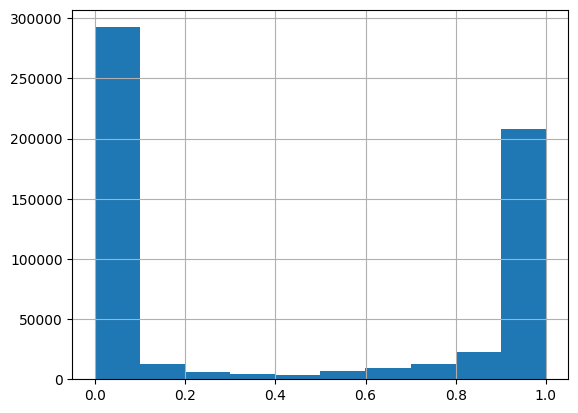

In [5]:
df.trn_tox.hist()

From this histogram we can conclude that the dataset is imbalanced in terms of toxicity level. Most of the samples either too neutral or too toxic.
Moreover trn_tox is mostly neutral.

<Axes: >

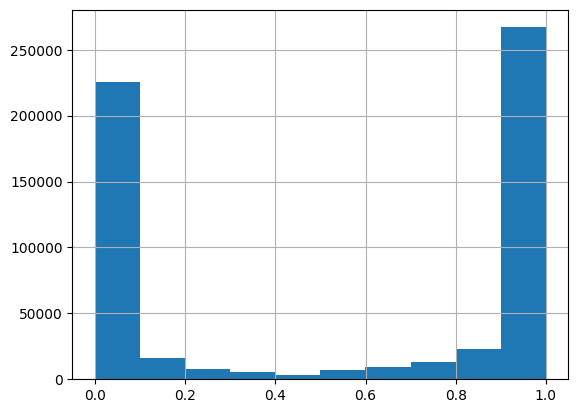

In [6]:
df.ref_tox.hist()


The same situation with ref_tox, but ref_tox, at opposite, tends to have higher toxicity score.

<Axes: >

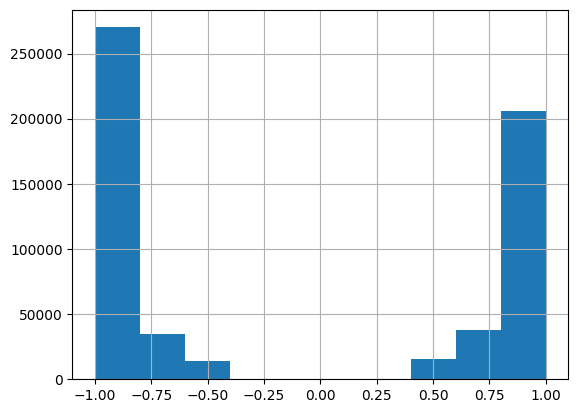

In [9]:
(df['trn_tox'] - df['ref_tox']).hist()

Mostly trn_tox is much smaller than ref_tox

<Axes: >

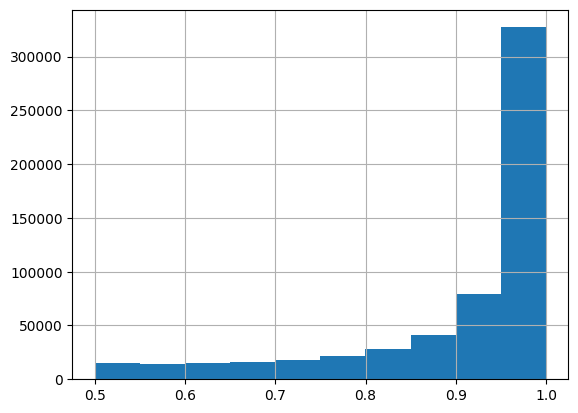

In [10]:
(df['trn_tox'] - df['ref_tox']).abs().hist()

So mostly there is a huge difference in toxicity level between original sentence and paraphrased translation. Also from this plot it's obvious how authors formed a dataset, all the samples with difference below 0.5 were not included into the final dataset.

### Confusion matrix

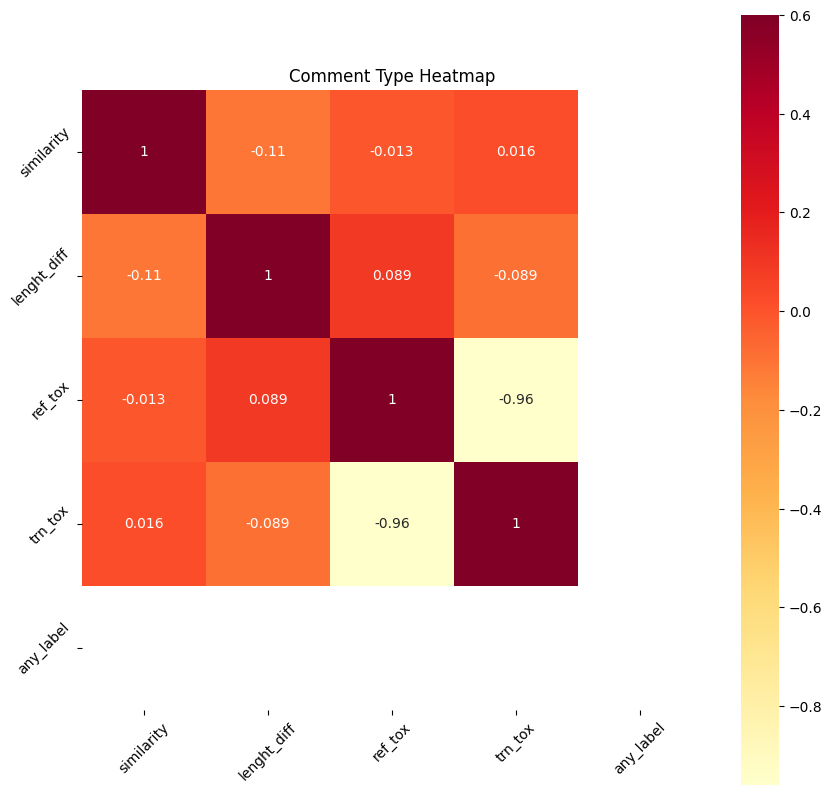

In [23]:
targets = list(df.columns[2:])
df_targets = df[targets].copy()

# How many rows are toxic?
toxic_rows = df_targets.sum(axis=1)
toxic_rows = (toxic_rows > 0)

# Create overall any_label feature
targets.append('any_label')
df_targets['any_label'] = toxic_rows

count_dic = {}
for comment_type in targets:
    counts = list()
    others = list(targets)
    df_selection = df_targets[(df_targets[comment_type] == 1)]
    others.remove(comment_type)
    counts.append(('total', len(df_selection)))
    for other in others:
        counts.append((other, df_selection[other].sum()))
    count_dic[comment_type] = counts


del (df_selection)


def heatmap(df, title):
    plt.figure('heatmap', figsize=[10, 10])
    plt.title(title)
    df_corr = df.corr()
    sns.heatmap(df_corr, vmax=0.6, square=True, annot=True, cmap='YlOrRd')
    plt.yticks(rotation=45)
    plt.xticks(rotation=45)
    plt.show()


heatmap(df_targets, 'Comment Type Heatmap')

Again, we see that ref_tox and trn_tox are in huge dependency with each other. All other fields cause no effect on toxicity fields, therefore they will not be used furher considerations.

## Data preprocessing

Since we need to detoxify text, we need to separate toxic sentences and their neutral paraphrases.

In [11]:
toxic = []
neutral = []
for i, row in df.iterrows():
    if row.ref_tox > row.trn_tox:
        toxic.append(row.reference)
        neutral.append(row.translation)
    else:
        neutral.append(row.reference)
        toxic.append(row.translation)

dataset = pd.DataFrame({'source': toxic, 'target': neutral})

Basic preprocessing for text data.

Later I decided to make it as minimal as I can, because it would be better to use just autotokenizers for deep learning models and apply them further, then to try to learn language structure and toxicity features from too clean data.

The one thing I did is to remove commas, otherwise transformation from tsv to csv lead to many errors. I tried to fix it without removing commas and I failed.

For classical ML models or just for classification purposes such "deep clean preprocessing" would be very useful. That's why I decided to leave some code here :)

In [57]:
import re
import string
from nltk.stem import LancasterStemmer, WordNetLemmatizer

punct = re.escape(string.punctuation)


def to_lowercase(text):
    """Convert all characters to lowercase in string of text"""
    return text.lower()


def remove_punctuation(text):
    """Remove punctuation from string of text"""
    regex = re.compile('[' + ',' + '0-9\r\t\n]')
    nopunct = regex.sub(" ", text)
    return nopunct


def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems


def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas


def preprocess(sample):

    sample = sample.lower()
    sample = remove_punctuation(sample)
    sample = " ".join(sample.split())

    return sample


def pipe(x): return preprocess(x)

For time oprimization purposes, I used only 10% of the dataset, but it was enough for my furher models.

In [58]:
small_df = dataset.sample(frac=0.1, random_state=42)

I decided to make 60/20/20 split for train, validation and test data.

In [59]:
train, validate, test = np.split(small_df.sample(frac=1, random_state=42), [
                                 int(.6*len(small_df)), int(.8*len(small_df))])

c:\Users\1\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [60]:
def preprocess_dataset(df):
    df['source'] = df['source'].apply(pipe)
    df['target'] = df['target'].apply(pipe)

    return df

In [61]:
train = preprocess_dataset(train)
validate = preprocess_dataset(validate)
test = preprocess_dataset(test)

In [62]:
train.head()

,source,target
226500,if we bring them up like this the lawyers will...,we bring them in looking like this civil liber...
261846,"she's all like ""oh there's all these guys havi...","she keeps saying ""there's a lot of guys who sl..."
104039,then you can suck my obituary.,you can write my obituary!
362426,you're like a nervous schoolgirl.,you see you look like a nervous schoolgirl.
217325,what the hell is that?,that was cool. - what is this?


In [67]:
train.to_csv("train.csv")
validate.to_csv("validate.csv")
test.to_csv("test.csv")